In [1]:
import tensorflow as tf
from tensorflow import keras
from skimage import io
from skimage.io import imread_collection
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import shutil

2023-02-26 19:32:41.353904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Fetch Data (Images)
We begin by fetching a dataset of 10,000 images from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com). We do so by requesting from the endpoint `thispersondoesnotexist.com/images` 10,000 (k) times.

In [2]:
image_path = "./images"

In [3]:
def save_image(image, count):
        with open(f'{image_path}/img_{count}.png', 'wb') as f:
            f.write(image)

In [4]:
def fetch_images(k: int, folder_name: str):
    """ 
    Fetch images from thispersondoesnotexist.com
    
    :param k: number of images to fetch
    :param folder_name: name of folder to save images to
    """
    if k < 1:
        return 0
    
    # Locals
    count = 0
    endpoint = 'image'
    url = f'https://thispersondoesnotexist.com/{endpoint}'
    while count < k:
        image = requests.get(url).content
        save_image(image)
        count += 1
        
        # A time.sleep(x) is recommended to avoid latency errors

We can now call this function and store the images locally

```python
fetch_images(k=8894, folder_name='images')
```

## Validating image
We should validate wether the image exists

In [5]:
def read_image(folder_name:str, idx:int):
    return io.imread(f'{folder_name}/img_{idx}.png')

In [6]:
def image_exists(folder_name:str) -> bool:
    """ 
    Check whether an image exists in folder_name
    
    :param folder_name: folder in which dataset images are located
    """
    try:
        # Default image 0
        image = read_image(image_path, 0)
        return True
    except:
        print(f'Image "img_0.png" in {folder_name} not found')
        return False

## Showing a batch
We can see a random batch of images from the dataset

In [7]:
def show_batch(batch):
    images = np.random.randint(low=0, high=len(batch), size=16) # get random indices
    fig = plt.figure(figsize= (4, 4)) 
    fig, axs = plt.subplots(4,4, sharex=True, sharey=True)
    cnt = 0 
    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(batch[images[cnt]]) # get image from batch at index 'i'
            cnt += 1
    plt.show()

### Image Attributes

In [8]:
def img_attr(batch):
    print(f'Images are {batch[0].shape[0]} by {batch[0].shape[1]} with {batch[0].shape[2]} channels')

Retreive all images from dataset

In [9]:
def read_collection(folder_name:str):
    return imread_collection(f'{folder_name}/*.png')

In [10]:
collection = read_collection(image_path)

In [11]:
len(collection)

8895

<Figure size 288x288 with 0 Axes>

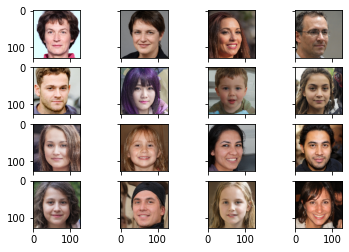

In [12]:
show_batch(collection)

In [13]:
collection[0].shape

(128, 128, 3)

In [14]:
img_attr(collection)

Images are 128 by 128 with 3 channels


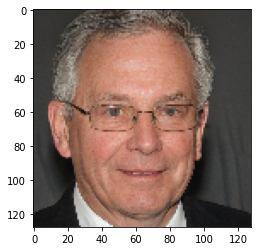

In [15]:
plt.imshow(collection[0])

### Resizing Images
As we can see, all images fetched are $1024 \times 1024 \times 3$, it is necessary we resize these into smaller dimensions to efficiently approach this DCGAN.

We import `CV2` to resize the images in `./images`

In [16]:
import cv2

We now resize every image in the `collection` and update them with given the new dimensions. All images in `collection` are named as their appropriate index in this list

In [17]:
def resize_image(image, size):
    resized_image = cv2.resize(image, dsize=size, interpolation=cv2.INTER_CUBIC)
    return Image.fromarray(resized_image)

for i in range(len(collection)):
    new_image = resize_image(collection[i], (128, 128))
    new_image.save(f'./128_imgs/img_{i}.png')

### Neural Network - 1.0
We begin by definning attributes. All images in the dataset are from [thispersondoesnotexistcom](https://www.thispersondoesnotexist.com), therefore all images are $1024 \times 1024$ with $3$ channels

In [18]:
rows = collection[0].shape[0]
cols = collection[0].shape[1]
channels = collection[0].shape[2]

In [19]:
image_shape = (rows, cols, channels)

`z_dim` represents the dimenions of the noise vector to be inputed into the generator

In [20]:
image_shape

(128, 128, 3)

We first import libraries to be used

In [21]:
from keras.layers import Dense, Flatten, Reshape, Conv2DTranspose, UpSampling2D, Activation, Conv2D, BatchNormalization, UpSampling2D
from keras.layers import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
import time

In [22]:
z_dim = 128 

We implement the schematics for $G(z)$ to generate $1024 \times 1024$ images from [Marchesi, Marco. (2017). Megapixel Size Image Creation using Generative Adversarial Networks.](https://www.researchgate.net/publication/317300265_Megapixel_Size_Image_Creation_using_Generative_Adversarial_Networks), [Karras, Aila. (2018). Progressive Growing of GANs for Improved Quality Stability, and Variation.](https://arxiv.org/pdf/1710.10196.pdf)

#### Generator 

In [23]:
from keras.utils.vis_utils import plot_model

In [24]:
def model_to_png(model, file_name:str):
    plot_model(model, to_file=f'{file_name}.png', show_shapes=True)

We can test our generator's functionality

In [25]:
def create_generator(z):
    model = Sequential()

    # Input Latent vector
    model.add(Dense(4*4*128, input_dim=z))
    model.add(Reshape((4, 4, 128)))
    
    # Conv
    model.add(Conv2DTranspose(128, kernel_size=4, strides=4, padding='valid'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.2))
    model.add(Conv2DTranspose(64, kernel_size=3, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.2))
    
    model.add(Conv2DTranspose(32, kernel_size=3, strides=4, padding='same'))   
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.2))
    model.add(Conv2DTranspose(16, kernel_size=3, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same'))    
    model.add(Activation('tanh'))
    return model

gen = create_generator(z_dim)
tf.random.set_seed(1)
noise = tf.random.normal([1, 128], mean=0, stddev=1)
img = gen.predict(noise)
img = tf.reshape(img, shape=(img.shape[1], img.shape[2], img.shape[3]))
print(img)
plt.imshow(img)
plt.show()

#### Discriminator

In [26]:
def create_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(3, kernel_size=1, padding='same', input_shape=img_shape))
    model.add(Conv2D(3, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(16, kernel_size=3, strides=2, padding='same', input_shape=img_shape))
    
    # Conv 2.0
    model.add(Conv2D(16, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(32, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 3.0
    model.add(Conv2D(32, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(64, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 3.0
    model.add(Conv2D(64, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 4.0
    model.add(Conv2D(128, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
    
    # Conv 5.0
    model.add(Conv2D(128, kernel_size=3, padding='same', input_shape=img_shape))
    model.add(Conv2D(128, kernel_size=2, strides=2, padding='valid', input_shape=img_shape))
              
    # Finalized
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

In [27]:
discriminator = create_discriminator(img_shape=image_shape)

2023-02-26 19:32:48.744066: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 3)       12        
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 3)       84        
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        2080      
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 64)        8

#### Set up (S) - 1.1 Create
We begin by initializing the discriminator and generator

In [28]:
generator = create_generator(z=z_dim)
discriminator = create_discriminator(img_shape=image_shape)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 128, 3)       12        
                                                                 
 conv2d_15 (Conv2D)          (None, 128, 128, 3)       84        
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 64, 16)        448       
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 16)        2320      
                                                                 
 conv2d_18 (Conv2D)          (None, 32, 32, 32)        2080      
                                                                 
 conv2d_19 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 16, 64)       

#### S - 1.2 Compile 
We know compile both models. <br>
NOTE: _Implement OS exisitng model loading_

##### Generator Compile

In [29]:
generator.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=0.001))

##### Discriminator Compile

In [30]:
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(learning_rate=0.001),
                      metrics=['accuracy'])

#### S - 1.3 Disable Discriminator Training

In [31]:
discriminator.trainable = False

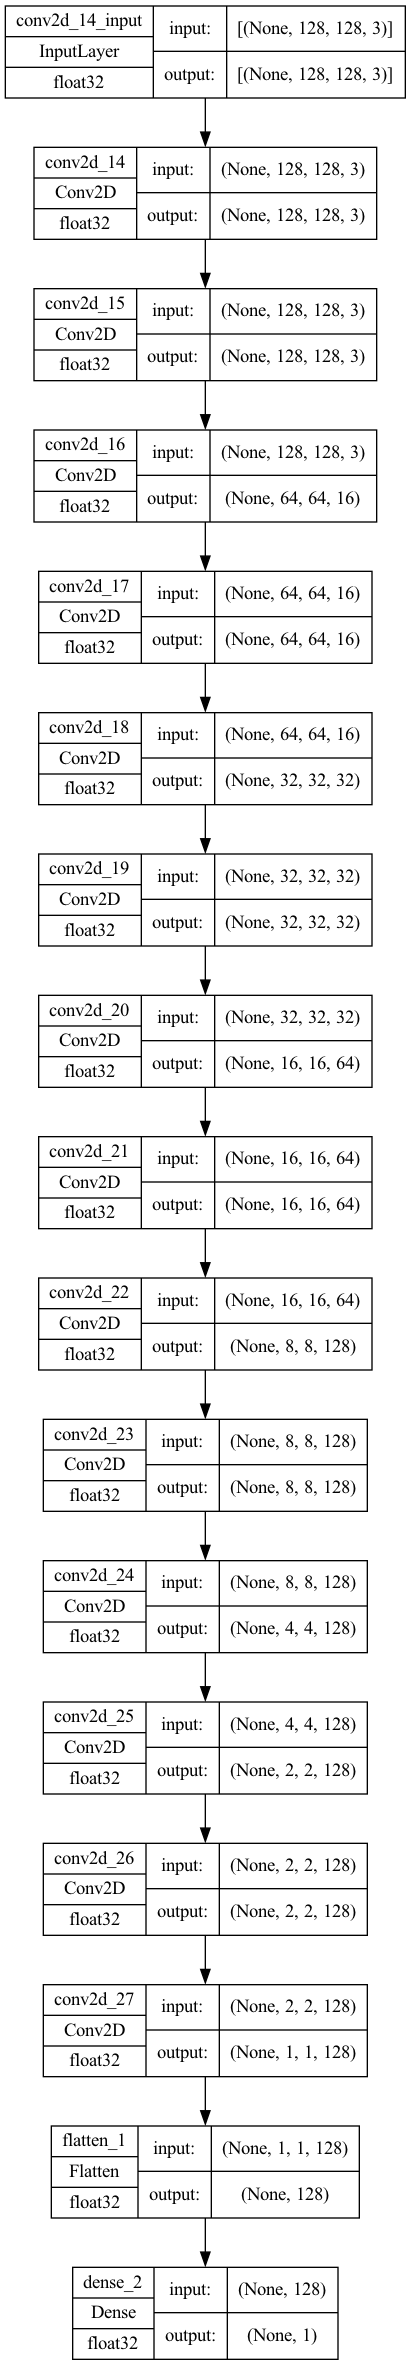

In [32]:
plot_model(discriminator, to_file='discriminator.png', show_shapes=True, show_dtype=True, show_layer_names=True)

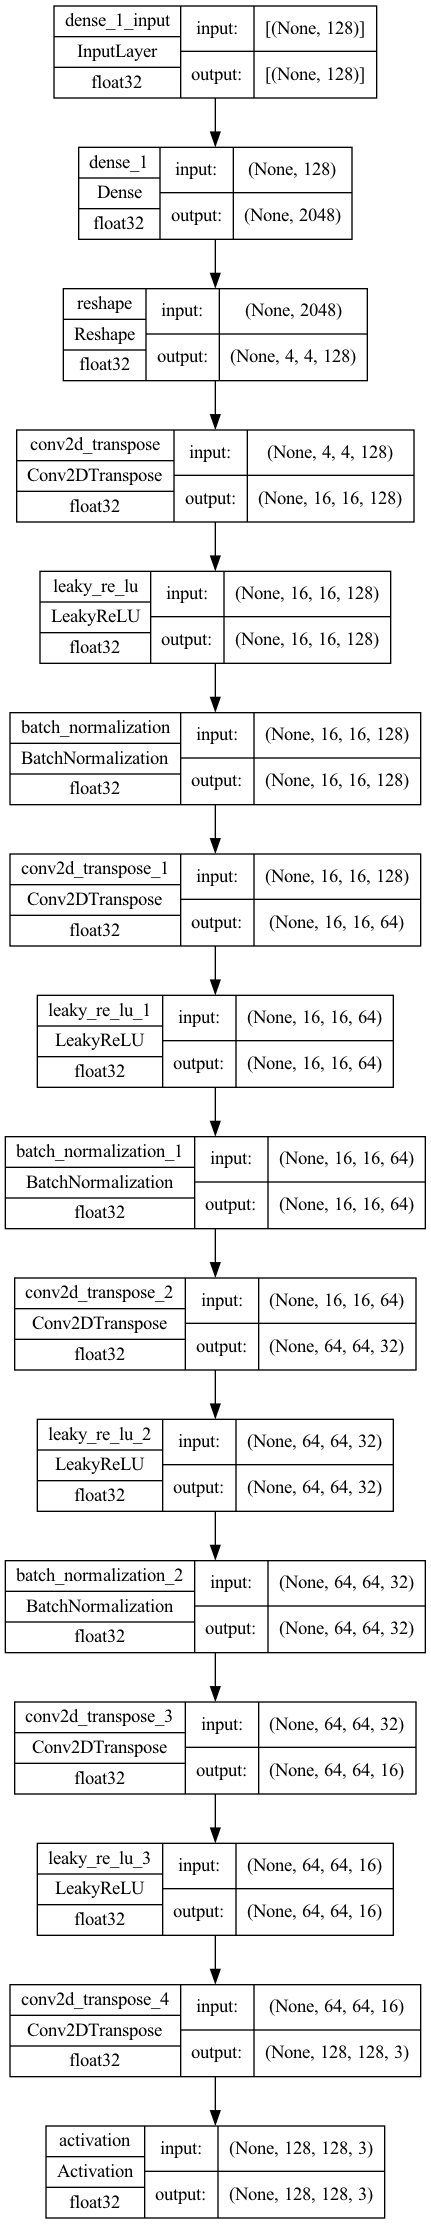

In [33]:
plot_model(generator, to_file='generator.png', show_shapes=True, show_dtype=True, show_layer_names=True)

In [34]:
def GAN(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    
    return model

In [35]:
gan = GAN(generator, discriminator)
gan.compile(loss='binary_crossentropy', 
                  optimizer=Adam())

#### TESTING DISCRIMINATOR
---
```python
noise = tf.random.normal([1, 512],)
img = generator(noise, training=False)
disc_output = discriminator(img, training=False)
print("Discriminator output on fake images:", disc_output.numpy())
real_image = collection[0]
disc_2_output = discriminator(np.expand_dims(real_image, axis=0), training=False)
```
---

#### S - 1.4 Training Iterations

#### S - 1.4.1 Params

In [36]:
iterations = 1000
batch_size = 32
sample_interval = 2

In [37]:
def time_stamp(msg:str, time):
    print(f'{msg} - {time}')

In [38]:
def get_time():
    return time.ctime(time.time())

In [39]:
discriminator_losses = []
gan_losses = []

In [40]:
def train_gan(iteraions:int, batch_size:int, sample_interval:int):
    data_images = read_collection(image_path)
    image_count = 0
    
    # Labels 
    time_stamp("Generating labels ...", get_time())
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))
    time_stamp("Finishing ...", get_time())
    
    # Training
    for iteration in range(iterations):
        time_stamp(f'Iteration {iteration} of {iterations}', get_time())
        
        # Collect batch
        time_stamp("Collecting images ...", get_time())
        random_indicies =  np.random.choice(len(data_images), size=200, replace=False)
        real_image_batch = np.array([data_images[i] for i in random_indicies]) / 127.5 - 1.0 # rescale [-1,1]
        time_stamp("Finishing ...", get_time())

        # Random batch of real images
        batch_of_real_indecies = np.random.randint(0, real_image_batch.shape[0], batch_size) # 0 - shape, # of ints
        batch_of_real_imgs = real_image_batch[batch_of_real_indecies]
        
        # Random batch of fake images
        z_fake = tf.random.normal([batch_size, 128], mean=0, stddev=1.0)

        generated_images = generator.predict(z_fake)
        
        # Train Discriminator -> [Loss, Accuracy]
        time_stamp("Training discriminator ...", get_time())
        discriminator_real_loss = discriminator.train_on_batch(batch_of_real_imgs, real_labels)       
        discriminator_fake_loss = discriminator.train_on_batch(generated_images, fake_labels)
        
        # Get Discriminator loss and accuracy
        discriminator_loss, accuracy = 0.5 * np.add(discriminator_real_loss, discriminator_fake_loss)
        
        # Train Generator
        time_stamp("Training generator ...", get_time())
        z_fake = tf.random.normal([batch_size, 128], mean=0, stddev=1.0)
        generated_images = generator.predict(z_fake)
        
        
        # Get Generator loss and accuracy
        gan_loss = gan.train_on_batch(z_fake, real_labels)
        time_stamp(f'Epoch time {iteration}', get_time())
        
        discriminator_losses.append(discriminator_loss)
        gan_losses.append(gan_loss)
        # Progress output
        if (iteration + 1) % sample_interval == 0:
            print("%d [D loss: %f, acc.:%.2f%%] [G loss: %f]" % (iteration + 1, discriminator_loss, 100.0* accuracy, gan_loss))
            
            # Generate random images
            z_generated = tf.random.normal([3*3, 128], mean=0, stddev=1.0)
            generate_images = generator.predict(z_generated)
            generate_images = 0.5 * generate_images + 0.5
            
            # Plot
            fig = plt.figure(figsize= (3, 3)) 
            fig, axs = plt.subplots(3, 3, sharex=True, sharey=True)
            cnt = 0 
            for i in range(3):
                for j in range(3):
                    axs[i, j].imshow(generate_images[cnt]) # get image from batch at index 'i'
                    cnt += 1
            plt.savefig(f'./gan_output_imgs_2/iteration{image_count}-gan.png')
            image_count += 1
            plt.show()
    generator.save('./generator_model')
    discriminator.save('./discriminator_model')
    gan.save('./gan_model')

#### Training the network
```python
train_gan(iterations, batch_size, sample_interval)
```

In [41]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Generating labels ... - Sun Feb 26 19:32:50 2023
Finishing ... - Sun Feb 26 19:32:50 2023
Iteration 0 of 1000 - Sun Feb 26 19:32:50 2023
Finishing ... - Sun Feb 26 19:32:51 2023
1/1 [==============================] - 0s 321ms/step
Training discriminator ... - Sun Feb 26 19:32:51 2023
Training generator ... - Sun Feb 26 19:32:52 2023
1/1 [==============================] - 0s 83ms/step
Epoch time 0 - Sun Feb 26 19:32:54 2023
Iteration 1 of 1000 - Sun Feb 26 19:32:54 2023
Finishing ... - Sun Feb 26 19:32:55 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:32:55 2023
Training generator ... - Sun Feb 26 19:32:55 2023
1/1 [==============================] - 0s 83ms/step
Epoch time 1 - Sun Feb 26 19:32:56 2023
2 [D loss: 0.663369, acc.:37.50%] [G loss: 0.539477]
1/1 [==============================] - 0s 220ms/step


<Figure size 216x216 with 0 Axes>

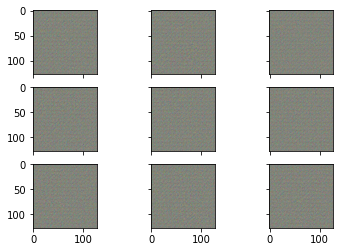

Iteration 2 of 1000 - Sun Feb 26 19:32:57 2023
Finishing ... - Sun Feb 26 19:32:57 2023
1/1 [==============================] - 0s 88ms/step
Training discriminator ... - Sun Feb 26 19:32:57 2023
Training generator ... - Sun Feb 26 19:32:58 2023
1/1 [==============================] - 0s 83ms/step
Epoch time 2 - Sun Feb 26 19:32:58 2023
Iteration 3 of 1000 - Sun Feb 26 19:32:58 2023
Finishing ... - Sun Feb 26 19:32:59 2023
1/1 [==============================] - 0s 88ms/step
Training discriminator ... - Sun Feb 26 19:32:59 2023
Training generator ... - Sun Feb 26 19:32:59 2023
1/1 [==============================] - 0s 81ms/step
Epoch time 3 - Sun Feb 26 19:33:00 2023
4 [D loss: 0.342635, acc.:82.81%] [G loss: 0.672429]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

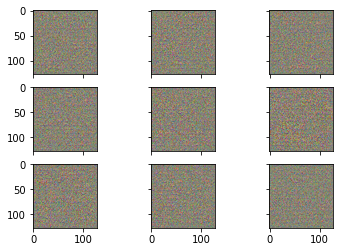

Iteration 4 of 1000 - Sun Feb 26 19:33:01 2023
Finishing ... - Sun Feb 26 19:33:01 2023
1/1 [==============================] - 0s 84ms/step
Training discriminator ... - Sun Feb 26 19:33:01 2023
Training generator ... - Sun Feb 26 19:33:01 2023
1/1 [==============================] - 0s 93ms/step
Epoch time 4 - Sun Feb 26 19:33:02 2023
Iteration 5 of 1000 - Sun Feb 26 19:33:02 2023
Finishing ... - Sun Feb 26 19:33:02 2023
1/1 [==============================] - 0s 90ms/step
Training discriminator ... - Sun Feb 26 19:33:02 2023
Training generator ... - Sun Feb 26 19:33:03 2023
1/1 [==============================] - 0s 84ms/step
Epoch time 5 - Sun Feb 26 19:33:03 2023
6 [D loss: 0.731799, acc.:78.12%] [G loss: 4.803565]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

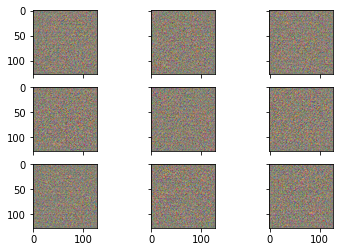

Iteration 6 of 1000 - Sun Feb 26 19:33:04 2023
Finishing ... - Sun Feb 26 19:33:05 2023
1/1 [==============================] - 0s 86ms/step
Training discriminator ... - Sun Feb 26 19:33:05 2023
Training generator ... - Sun Feb 26 19:33:05 2023
1/1 [==============================] - 0s 83ms/step
Epoch time 6 - Sun Feb 26 19:33:06 2023
Iteration 7 of 1000 - Sun Feb 26 19:33:06 2023
Finishing ... - Sun Feb 26 19:33:06 2023
1/1 [==============================] - 0s 90ms/step
Training discriminator ... - Sun Feb 26 19:33:06 2023
Training generator ... - Sun Feb 26 19:33:06 2023
1/1 [==============================] - 0s 92ms/step
Epoch time 7 - Sun Feb 26 19:33:07 2023
8 [D loss: 0.052494, acc.:98.44%] [G loss: 11.233324]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

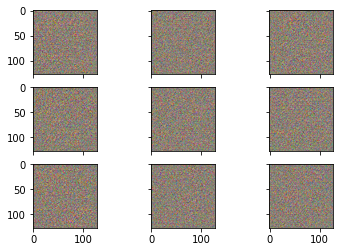

Iteration 8 of 1000 - Sun Feb 26 19:33:08 2023
Finishing ... - Sun Feb 26 19:33:08 2023
1/1 [==============================] - 0s 87ms/step
Training discriminator ... - Sun Feb 26 19:33:08 2023
Training generator ... - Sun Feb 26 19:33:09 2023
1/1 [==============================] - 0s 81ms/step
Epoch time 8 - Sun Feb 26 19:33:09 2023
Iteration 9 of 1000 - Sun Feb 26 19:33:09 2023
Finishing ... - Sun Feb 26 19:33:10 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:33:10 2023
Training generator ... - Sun Feb 26 19:33:10 2023
1/1 [==============================] - 0s 83ms/step
Epoch time 9 - Sun Feb 26 19:33:11 2023
10 [D loss: 0.110229, acc.:96.88%] [G loss: 12.456429]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

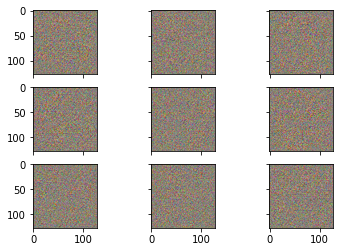

Iteration 10 of 1000 - Sun Feb 26 19:33:12 2023
Finishing ... - Sun Feb 26 19:33:12 2023
1/1 [==============================] - 0s 87ms/step
Training discriminator ... - Sun Feb 26 19:33:12 2023
Training generator ... - Sun Feb 26 19:33:13 2023
1/1 [==============================] - 0s 88ms/step
Epoch time 10 - Sun Feb 26 19:33:13 2023
Iteration 11 of 1000 - Sun Feb 26 19:33:13 2023
Finishing ... - Sun Feb 26 19:33:14 2023
1/1 [==============================] - 0s 91ms/step
Training discriminator ... - Sun Feb 26 19:33:14 2023
Training generator ... - Sun Feb 26 19:33:14 2023
1/1 [==============================] - 0s 87ms/step
Epoch time 11 - Sun Feb 26 19:33:15 2023
12 [D loss: 0.001187, acc.:100.00%] [G loss: 44.414551]
1/1 [==============================] - 0s 41ms/step


<Figure size 216x216 with 0 Axes>

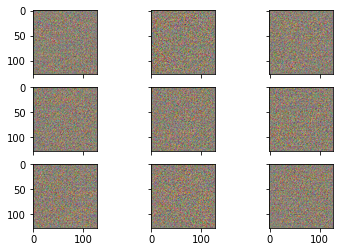

Iteration 12 of 1000 - Sun Feb 26 19:33:16 2023
Finishing ... - Sun Feb 26 19:33:16 2023
1/1 [==============================] - 0s 87ms/step
Training discriminator ... - Sun Feb 26 19:33:16 2023
Training generator ... - Sun Feb 26 19:33:16 2023
1/1 [==============================] - 0s 93ms/step
Epoch time 12 - Sun Feb 26 19:33:17 2023
Iteration 13 of 1000 - Sun Feb 26 19:33:17 2023
Finishing ... - Sun Feb 26 19:33:17 2023
1/1 [==============================] - 0s 90ms/step
Training discriminator ... - Sun Feb 26 19:33:17 2023
Training generator ... - Sun Feb 26 19:33:18 2023
1/1 [==============================] - 0s 91ms/step
Epoch time 13 - Sun Feb 26 19:33:18 2023
14 [D loss: 0.101755, acc.:93.75%] [G loss: 21.378645]
1/1 [==============================] - 0s 42ms/step


<Figure size 216x216 with 0 Axes>

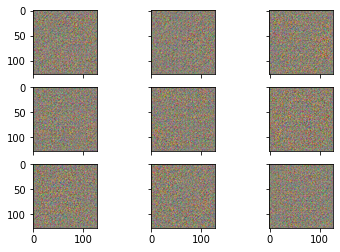

Iteration 14 of 1000 - Sun Feb 26 19:33:19 2023
Finishing ... - Sun Feb 26 19:33:20 2023
1/1 [==============================] - 0s 87ms/step
Training discriminator ... - Sun Feb 26 19:33:20 2023
Training generator ... - Sun Feb 26 19:33:20 2023
1/1 [==============================] - 0s 84ms/step
Epoch time 14 - Sun Feb 26 19:33:21 2023
Iteration 15 of 1000 - Sun Feb 26 19:33:21 2023
Finishing ... - Sun Feb 26 19:33:21 2023
1/1 [==============================] - 0s 89ms/step
Training discriminator ... - Sun Feb 26 19:33:21 2023
Training generator ... - Sun Feb 26 19:33:22 2023
1/1 [==============================] - 0s 85ms/step
Epoch time 15 - Sun Feb 26 19:33:22 2023
16 [D loss: 0.023815, acc.:100.00%] [G loss: 7.646455]
1/1 [==============================] - 0s 39ms/step


<Figure size 216x216 with 0 Axes>

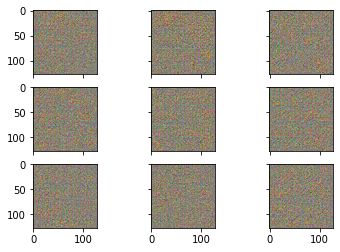

Iteration 16 of 1000 - Sun Feb 26 19:33:23 2023
Finishing ... - Sun Feb 26 19:33:23 2023
1/1 [==============================] - 0s 87ms/step
Training discriminator ... - Sun Feb 26 19:33:23 2023
Training generator ... - Sun Feb 26 19:33:24 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 16 - Sun Feb 26 19:33:24 2023
Iteration 17 of 1000 - Sun Feb 26 19:33:24 2023
Finishing ... - Sun Feb 26 19:33:25 2023
1/1 [==============================] - 0s 91ms/step
Training discriminator ... - Sun Feb 26 19:33:25 2023
Training generator ... - Sun Feb 26 19:33:25 2023
1/1 [==============================] - 0s 88ms/step
Epoch time 17 - Sun Feb 26 19:33:26 2023
18 [D loss: 0.051768, acc.:100.00%] [G loss: 5.468970]
1/1 [==============================] - 0s 41ms/step


<Figure size 216x216 with 0 Axes>

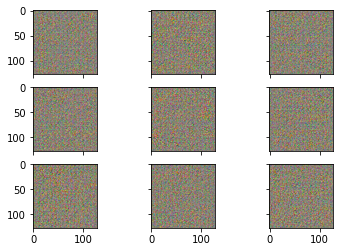

Iteration 18 of 1000 - Sun Feb 26 19:33:27 2023
Finishing ... - Sun Feb 26 19:33:27 2023
1/1 [==============================] - 0s 88ms/step
Training discriminator ... - Sun Feb 26 19:33:27 2023
Training generator ... - Sun Feb 26 19:33:28 2023
1/1 [==============================] - 0s 88ms/step
Epoch time 18 - Sun Feb 26 19:33:28 2023
Iteration 19 of 1000 - Sun Feb 26 19:33:28 2023
Finishing ... - Sun Feb 26 19:33:28 2023
1/1 [==============================] - 0s 90ms/step
Training discriminator ... - Sun Feb 26 19:33:29 2023
Training generator ... - Sun Feb 26 19:33:29 2023
1/1 [==============================] - 0s 86ms/step
Epoch time 19 - Sun Feb 26 19:33:29 2023
20 [D loss: 0.003949, acc.:100.00%] [G loss: 16.676994]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

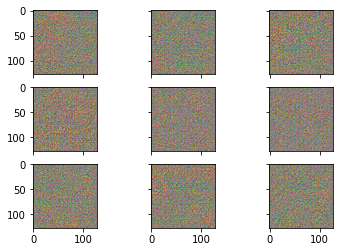

Iteration 20 of 1000 - Sun Feb 26 19:33:30 2023
Finishing ... - Sun Feb 26 19:33:31 2023
1/1 [==============================] - 0s 96ms/step
Training discriminator ... - Sun Feb 26 19:33:31 2023
Training generator ... - Sun Feb 26 19:33:32 2023
1/1 [==============================] - 0s 131ms/step
Epoch time 20 - Sun Feb 26 19:33:32 2023
Iteration 21 of 1000 - Sun Feb 26 19:33:32 2023
Finishing ... - Sun Feb 26 19:33:33 2023
1/1 [==============================] - 0s 118ms/step
Training discriminator ... - Sun Feb 26 19:33:33 2023
Training generator ... - Sun Feb 26 19:33:33 2023
1/1 [==============================] - 0s 86ms/step
Epoch time 21 - Sun Feb 26 19:33:34 2023
22 [D loss: 0.008537, acc.:100.00%] [G loss: 21.304703]
1/1 [==============================] - 0s 56ms/step


<Figure size 216x216 with 0 Axes>

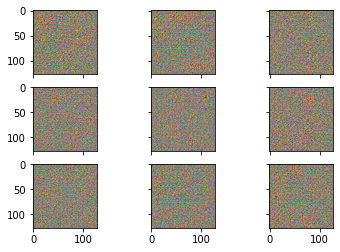

Iteration 22 of 1000 - Sun Feb 26 19:33:36 2023
Finishing ... - Sun Feb 26 19:33:36 2023
1/1 [==============================] - 0s 102ms/step
Training discriminator ... - Sun Feb 26 19:33:36 2023
Training generator ... - Sun Feb 26 19:33:37 2023
1/1 [==============================] - 0s 101ms/step
Epoch time 22 - Sun Feb 26 19:33:38 2023
Iteration 23 of 1000 - Sun Feb 26 19:33:38 2023
Finishing ... - Sun Feb 26 19:33:38 2023
1/1 [==============================] - 0s 109ms/step
Training discriminator ... - Sun Feb 26 19:33:38 2023
Training generator ... - Sun Feb 26 19:33:39 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 23 - Sun Feb 26 19:33:39 2023
24 [D loss: 0.001329, acc.:100.00%] [G loss: 15.508368]
1/1 [==============================] - 0s 52ms/step


<Figure size 216x216 with 0 Axes>

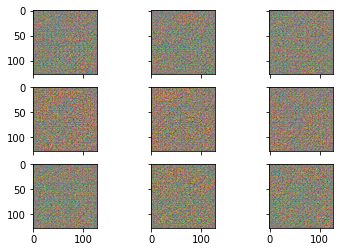

Iteration 24 of 1000 - Sun Feb 26 19:33:41 2023
Finishing ... - Sun Feb 26 19:33:41 2023
1/1 [==============================] - 0s 97ms/step
Training discriminator ... - Sun Feb 26 19:33:41 2023
Training generator ... - Sun Feb 26 19:33:42 2023
1/1 [==============================] - 0s 119ms/step
Epoch time 24 - Sun Feb 26 19:33:42 2023
Iteration 25 of 1000 - Sun Feb 26 19:33:42 2023
Finishing ... - Sun Feb 26 19:33:43 2023
1/1 [==============================] - 0s 98ms/step
Training discriminator ... - Sun Feb 26 19:33:43 2023
Training generator ... - Sun Feb 26 19:33:43 2023
1/1 [==============================] - 0s 105ms/step
Epoch time 25 - Sun Feb 26 19:33:44 2023
26 [D loss: 0.000273, acc.:100.00%] [G loss: 37.483459]
1/1 [==============================] - 0s 47ms/step


<Figure size 216x216 with 0 Axes>

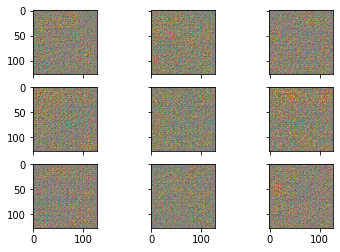

Iteration 26 of 1000 - Sun Feb 26 19:33:45 2023
Finishing ... - Sun Feb 26 19:33:45 2023
1/1 [==============================] - 0s 97ms/step
Training discriminator ... - Sun Feb 26 19:33:45 2023
Training generator ... - Sun Feb 26 19:33:46 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 26 - Sun Feb 26 19:33:46 2023
Iteration 27 of 1000 - Sun Feb 26 19:33:46 2023
Finishing ... - Sun Feb 26 19:33:47 2023
1/1 [==============================] - 0s 100ms/step
Training discriminator ... - Sun Feb 26 19:33:47 2023
Training generator ... - Sun Feb 26 19:33:47 2023
1/1 [==============================] - 0s 87ms/step
Epoch time 27 - Sun Feb 26 19:33:48 2023
28 [D loss: 0.000778, acc.:100.00%] [G loss: 49.862572]
1/1 [==============================] - 0s 48ms/step


<Figure size 216x216 with 0 Axes>

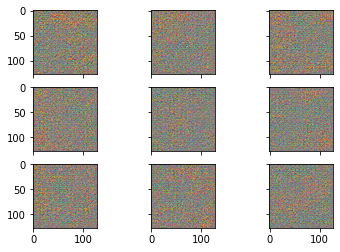

Iteration 28 of 1000 - Sun Feb 26 19:33:49 2023
Finishing ... - Sun Feb 26 19:33:49 2023
1/1 [==============================] - 0s 91ms/step
Training discriminator ... - Sun Feb 26 19:33:49 2023
Training generator ... - Sun Feb 26 19:33:50 2023
1/1 [==============================] - 0s 93ms/step
Epoch time 28 - Sun Feb 26 19:33:50 2023
Iteration 29 of 1000 - Sun Feb 26 19:33:50 2023
Finishing ... - Sun Feb 26 19:33:51 2023
1/1 [==============================] - 0s 99ms/step
Training discriminator ... - Sun Feb 26 19:33:51 2023
Training generator ... - Sun Feb 26 19:33:51 2023
1/1 [==============================] - 0s 93ms/step
Epoch time 29 - Sun Feb 26 19:33:52 2023
30 [D loss: 0.179849, acc.:96.88%] [G loss: 43.221420]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

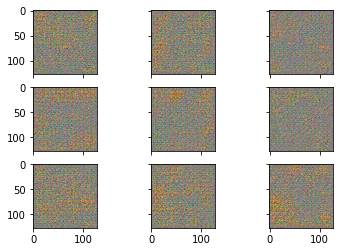

Iteration 30 of 1000 - Sun Feb 26 19:33:53 2023
Finishing ... - Sun Feb 26 19:33:53 2023
1/1 [==============================] - 0s 90ms/step
Training discriminator ... - Sun Feb 26 19:33:53 2023
Training generator ... - Sun Feb 26 19:33:54 2023
1/1 [==============================] - 0s 83ms/step
Epoch time 30 - Sun Feb 26 19:33:54 2023
Iteration 31 of 1000 - Sun Feb 26 19:33:54 2023
Finishing ... - Sun Feb 26 19:33:55 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:33:55 2023
Training generator ... - Sun Feb 26 19:33:55 2023
1/1 [==============================] - 0s 93ms/step
Epoch time 31 - Sun Feb 26 19:33:56 2023
32 [D loss: 0.027891, acc.:100.00%] [G loss: 48.131027]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

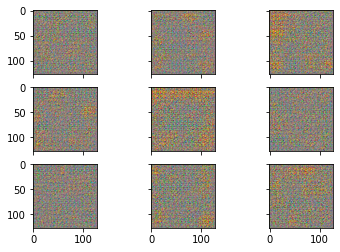

Iteration 32 of 1000 - Sun Feb 26 19:33:57 2023
Finishing ... - Sun Feb 26 19:33:57 2023
1/1 [==============================] - 0s 96ms/step
Training discriminator ... - Sun Feb 26 19:33:57 2023
Training generator ... - Sun Feb 26 19:33:58 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 32 - Sun Feb 26 19:33:58 2023
Iteration 33 of 1000 - Sun Feb 26 19:33:58 2023
Finishing ... - Sun Feb 26 19:33:58 2023
1/1 [==============================] - 0s 96ms/step
Training discriminator ... - Sun Feb 26 19:33:59 2023
Training generator ... - Sun Feb 26 19:33:59 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 33 - Sun Feb 26 19:33:59 2023
34 [D loss: 0.719688, acc.:93.75%] [G loss: 46.893028]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

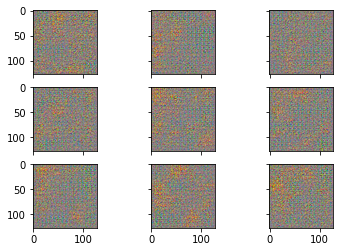

Iteration 34 of 1000 - Sun Feb 26 19:34:01 2023
Finishing ... - Sun Feb 26 19:34:01 2023
1/1 [==============================] - 0s 91ms/step
Training discriminator ... - Sun Feb 26 19:34:01 2023
Training generator ... - Sun Feb 26 19:34:02 2023
1/1 [==============================] - 0s 97ms/step
Epoch time 34 - Sun Feb 26 19:34:02 2023
Iteration 35 of 1000 - Sun Feb 26 19:34:02 2023
Finishing ... - Sun Feb 26 19:34:02 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:34:03 2023
Training generator ... - Sun Feb 26 19:34:03 2023
1/1 [==============================] - 0s 86ms/step
Epoch time 35 - Sun Feb 26 19:34:03 2023
36 [D loss: 0.338254, acc.:92.19%] [G loss: 54.545166]
1/1 [==============================] - 0s 42ms/step


<Figure size 216x216 with 0 Axes>

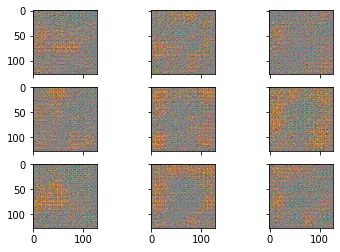

Iteration 36 of 1000 - Sun Feb 26 19:34:04 2023
Finishing ... - Sun Feb 26 19:34:05 2023
1/1 [==============================] - 0s 91ms/step
Training discriminator ... - Sun Feb 26 19:34:05 2023
Training generator ... - Sun Feb 26 19:34:05 2023
1/1 [==============================] - 0s 92ms/step
Epoch time 36 - Sun Feb 26 19:34:06 2023
Iteration 37 of 1000 - Sun Feb 26 19:34:06 2023
Finishing ... - Sun Feb 26 19:34:06 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:34:06 2023
Training generator ... - Sun Feb 26 19:34:07 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 37 - Sun Feb 26 19:34:07 2023
38 [D loss: 0.728371, acc.:92.19%] [G loss: 33.932915]
1/1 [==============================] - 0s 46ms/step


<Figure size 216x216 with 0 Axes>

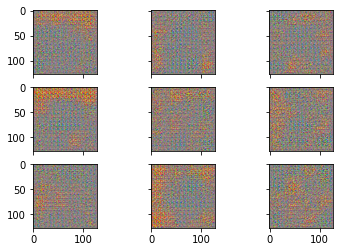

Iteration 38 of 1000 - Sun Feb 26 19:34:08 2023
Finishing ... - Sun Feb 26 19:34:08 2023
1/1 [==============================] - 0s 97ms/step
Training discriminator ... - Sun Feb 26 19:34:09 2023
Training generator ... - Sun Feb 26 19:34:09 2023
1/1 [==============================] - 0s 92ms/step
Epoch time 38 - Sun Feb 26 19:34:09 2023
Iteration 39 of 1000 - Sun Feb 26 19:34:09 2023
Finishing ... - Sun Feb 26 19:34:10 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:34:10 2023
Training generator ... - Sun Feb 26 19:34:10 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 39 - Sun Feb 26 19:34:11 2023
40 [D loss: 0.136998, acc.:96.88%] [G loss: 26.902731]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

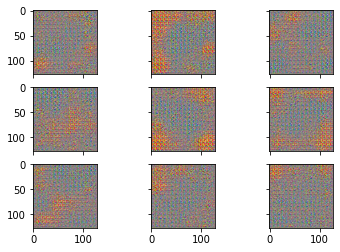

Iteration 40 of 1000 - Sun Feb 26 19:34:12 2023
Finishing ... - Sun Feb 26 19:34:12 2023
1/1 [==============================] - 0s 91ms/step
Training discriminator ... - Sun Feb 26 19:34:12 2023
Training generator ... - Sun Feb 26 19:34:13 2023
1/1 [==============================] - 0s 93ms/step
Epoch time 40 - Sun Feb 26 19:34:13 2023
Iteration 41 of 1000 - Sun Feb 26 19:34:13 2023
Finishing ... - Sun Feb 26 19:34:14 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:34:14 2023
Training generator ... - Sun Feb 26 19:34:14 2023
1/1 [==============================] - 0s 95ms/step
Epoch time 41 - Sun Feb 26 19:34:15 2023
42 [D loss: 0.037115, acc.:98.44%] [G loss: 90.112640]
1/1 [==============================] - 0s 47ms/step


<Figure size 216x216 with 0 Axes>

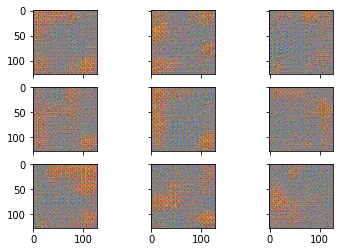

Iteration 42 of 1000 - Sun Feb 26 19:34:16 2023
Finishing ... - Sun Feb 26 19:34:16 2023
1/1 [==============================] - 0s 90ms/step
Training discriminator ... - Sun Feb 26 19:34:16 2023
Training generator ... - Sun Feb 26 19:34:17 2023
1/1 [==============================] - 0s 103ms/step
Epoch time 42 - Sun Feb 26 19:34:17 2023
Iteration 43 of 1000 - Sun Feb 26 19:34:17 2023
Finishing ... - Sun Feb 26 19:34:17 2023
1/1 [==============================] - 0s 93ms/step
Training discriminator ... - Sun Feb 26 19:34:18 2023
Training generator ... - Sun Feb 26 19:34:18 2023
1/1 [==============================] - 0s 92ms/step
Epoch time 43 - Sun Feb 26 19:34:18 2023
44 [D loss: 0.005806, acc.:100.00%] [G loss: 87.823898]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

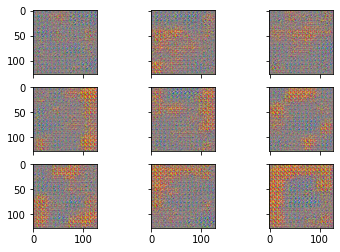

Iteration 44 of 1000 - Sun Feb 26 19:34:19 2023
Finishing ... - Sun Feb 26 19:34:20 2023
1/1 [==============================] - 0s 96ms/step
Training discriminator ... - Sun Feb 26 19:34:20 2023
Training generator ... - Sun Feb 26 19:34:20 2023
1/1 [==============================] - 0s 85ms/step
Epoch time 44 - Sun Feb 26 19:34:21 2023
Iteration 45 of 1000 - Sun Feb 26 19:34:21 2023
Finishing ... - Sun Feb 26 19:34:21 2023
1/1 [==============================] - 0s 96ms/step
Training discriminator ... - Sun Feb 26 19:34:21 2023
Training generator ... - Sun Feb 26 19:34:22 2023
1/1 [==============================] - 0s 98ms/step
Epoch time 45 - Sun Feb 26 19:34:22 2023
46 [D loss: 0.000023, acc.:100.00%] [G loss: 61.240940]
1/1 [==============================] - 0s 40ms/step


<Figure size 216x216 with 0 Axes>

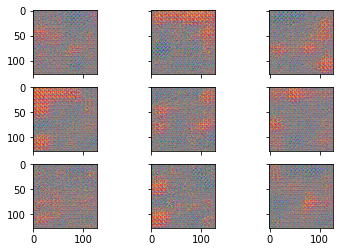

Iteration 46 of 1000 - Sun Feb 26 19:34:23 2023
Finishing ... - Sun Feb 26 19:34:24 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:34:24 2023
Training generator ... - Sun Feb 26 19:34:24 2023
1/1 [==============================] - 0s 92ms/step
Epoch time 46 - Sun Feb 26 19:34:25 2023
Iteration 47 of 1000 - Sun Feb 26 19:34:25 2023
Finishing ... - Sun Feb 26 19:34:25 2023
1/1 [==============================] - 0s 96ms/step
Training discriminator ... - Sun Feb 26 19:34:25 2023
Training generator ... - Sun Feb 26 19:34:26 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 47 - Sun Feb 26 19:34:26 2023
48 [D loss: 0.000008, acc.:100.00%] [G loss: 234.324249]
1/1 [==============================] - 0s 47ms/step


<Figure size 216x216 with 0 Axes>

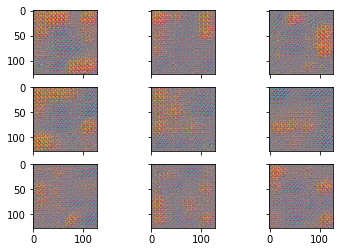

Iteration 48 of 1000 - Sun Feb 26 19:34:27 2023
Finishing ... - Sun Feb 26 19:34:28 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:34:28 2023
Training generator ... - Sun Feb 26 19:34:28 2023
1/1 [==============================] - 0s 92ms/step
Epoch time 48 - Sun Feb 26 19:34:28 2023
Iteration 49 of 1000 - Sun Feb 26 19:34:28 2023
Finishing ... - Sun Feb 26 19:34:29 2023
1/1 [==============================] - 0s 96ms/step
Training discriminator ... - Sun Feb 26 19:34:29 2023
Training generator ... - Sun Feb 26 19:34:29 2023
1/1 [==============================] - 0s 86ms/step
Epoch time 49 - Sun Feb 26 19:34:30 2023
50 [D loss: 0.002668, acc.:100.00%] [G loss: 484.158936]
1/1 [==============================] - 0s 42ms/step


<Figure size 216x216 with 0 Axes>

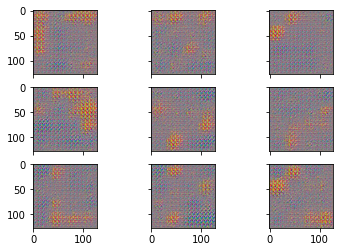

Iteration 50 of 1000 - Sun Feb 26 19:34:31 2023
Finishing ... - Sun Feb 26 19:34:31 2023
1/1 [==============================] - 0s 96ms/step
Training discriminator ... - Sun Feb 26 19:34:31 2023
Training generator ... - Sun Feb 26 19:34:32 2023
1/1 [==============================] - 0s 94ms/step
Epoch time 50 - Sun Feb 26 19:34:32 2023
Iteration 51 of 1000 - Sun Feb 26 19:34:32 2023
Finishing ... - Sun Feb 26 19:34:33 2023
1/1 [==============================] - 0s 92ms/step
Training discriminator ... - Sun Feb 26 19:34:33 2023
Training generator ... - Sun Feb 26 19:34:33 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 51 - Sun Feb 26 19:34:34 2023
52 [D loss: 0.000022, acc.:100.00%] [G loss: 449.513489]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

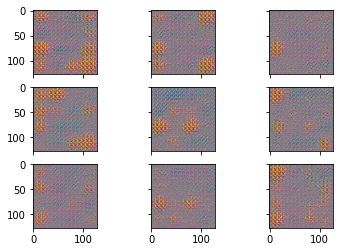

Iteration 52 of 1000 - Sun Feb 26 19:34:35 2023
Finishing ... - Sun Feb 26 19:34:35 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:34:35 2023
Training generator ... - Sun Feb 26 19:34:35 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 52 - Sun Feb 26 19:34:36 2023
Iteration 53 of 1000 - Sun Feb 26 19:34:36 2023
Finishing ... - Sun Feb 26 19:34:36 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:34:36 2023
Training generator ... - Sun Feb 26 19:34:37 2023
1/1 [==============================] - 0s 95ms/step
Epoch time 53 - Sun Feb 26 19:34:37 2023
54 [D loss: 4.569589, acc.:93.75%] [G loss: 267.726318]
1/1 [==============================] - 0s 46ms/step


<Figure size 216x216 with 0 Axes>

Iteration 54 of 1000 - Sun Feb 26 19:34:38 2023
Finishing ... - Sun Feb 26 19:34:39 2023
1/1 [==============================] - 0s 96ms/step
Training discriminator ... - Sun Feb 26 19:34:39 2023
Training generator ... - Sun Feb 26 19:34:39 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 54 - Sun Feb 26 19:34:40 2023
Iteration 55 of 1000 - Sun Feb 26 19:34:40 2023
Finishing ... - Sun Feb 26 19:34:40 2023
1/1 [==============================] - 0s 99ms/step
Training discriminator ... - Sun Feb 26 19:34:40 2023
Training generator ... - Sun Feb 26 19:34:41 2023
1/1 [==============================] - 0s 86ms/step
Epoch time 55 - Sun Feb 26 19:34:41 2023
56 [D loss: 0.000010, acc.:100.00%] [G loss: 158.329346]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

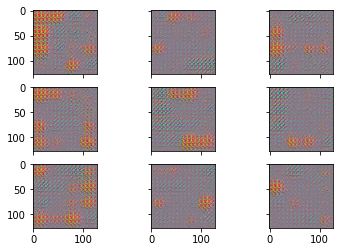

Iteration 56 of 1000 - Sun Feb 26 19:34:42 2023
Finishing ... - Sun Feb 26 19:34:43 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:34:43 2023
Training generator ... - Sun Feb 26 19:34:43 2023
1/1 [==============================] - 0s 87ms/step
Epoch time 56 - Sun Feb 26 19:34:44 2023
Iteration 57 of 1000 - Sun Feb 26 19:34:44 2023
Finishing ... - Sun Feb 26 19:34:44 2023
1/1 [==============================] - 0s 98ms/step
Training discriminator ... - Sun Feb 26 19:34:44 2023
Training generator ... - Sun Feb 26 19:34:45 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 57 - Sun Feb 26 19:34:45 2023
58 [D loss: 17.885256, acc.:53.12%] [G loss: 35.968098]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

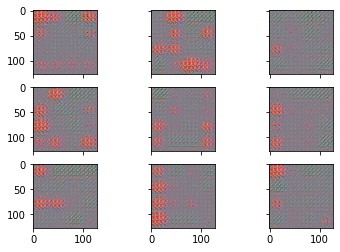

Iteration 58 of 1000 - Sun Feb 26 19:34:46 2023
Finishing ... - Sun Feb 26 19:34:47 2023
1/1 [==============================] - 0s 98ms/step
Training discriminator ... - Sun Feb 26 19:34:47 2023
Training generator ... - Sun Feb 26 19:34:47 2023
1/1 [==============================] - 0s 91ms/step
Epoch time 58 - Sun Feb 26 19:34:48 2023
Iteration 59 of 1000 - Sun Feb 26 19:34:48 2023
Finishing ... - Sun Feb 26 19:34:48 2023
1/1 [==============================] - 0s 92ms/step
Training discriminator ... - Sun Feb 26 19:34:48 2023
Training generator ... - Sun Feb 26 19:34:49 2023
1/1 [==============================] - 0s 79ms/step
Epoch time 59 - Sun Feb 26 19:34:49 2023
60 [D loss: 0.190368, acc.:96.88%] [G loss: 77.803467]
1/1 [==============================] - 0s 51ms/step


<Figure size 216x216 with 0 Axes>

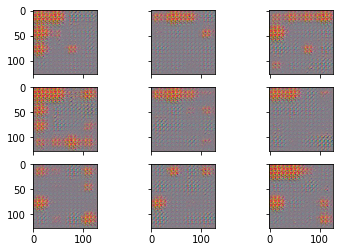

Iteration 60 of 1000 - Sun Feb 26 19:34:50 2023
Finishing ... - Sun Feb 26 19:34:50 2023
1/1 [==============================] - 0s 97ms/step
Training discriminator ... - Sun Feb 26 19:34:51 2023
Training generator ... - Sun Feb 26 19:34:51 2023
1/1 [==============================] - 0s 88ms/step
Epoch time 60 - Sun Feb 26 19:34:51 2023
Iteration 61 of 1000 - Sun Feb 26 19:34:51 2023
Finishing ... - Sun Feb 26 19:34:52 2023
1/1 [==============================] - 0s 92ms/step
Training discriminator ... - Sun Feb 26 19:34:52 2023
Training generator ... - Sun Feb 26 19:34:52 2023
1/1 [==============================] - 0s 87ms/step
Epoch time 61 - Sun Feb 26 19:34:53 2023
62 [D loss: 5.759312, acc.:23.44%] [G loss: 61.128654]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

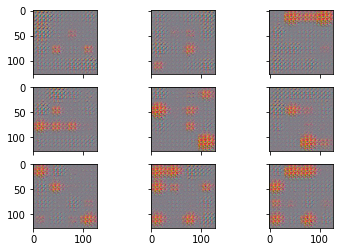

Iteration 62 of 1000 - Sun Feb 26 19:34:54 2023
Finishing ... - Sun Feb 26 19:34:54 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:34:54 2023
Training generator ... - Sun Feb 26 19:34:55 2023
1/1 [==============================] - 0s 86ms/step
Epoch time 62 - Sun Feb 26 19:34:55 2023
Iteration 63 of 1000 - Sun Feb 26 19:34:55 2023
Finishing ... - Sun Feb 26 19:34:56 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:34:56 2023
Training generator ... - Sun Feb 26 19:34:56 2023
1/1 [==============================] - 0s 87ms/step
Epoch time 63 - Sun Feb 26 19:34:57 2023
64 [D loss: 26.141291, acc.:48.44%] [G loss: 2.377704]
1/1 [==============================] - 0s 47ms/step


<Figure size 216x216 with 0 Axes>

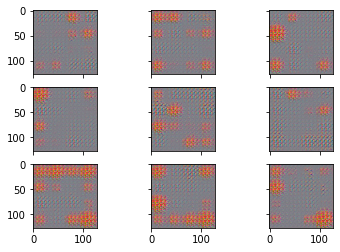

Iteration 64 of 1000 - Sun Feb 26 19:34:58 2023
Finishing ... - Sun Feb 26 19:34:58 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:34:58 2023
Training generator ... - Sun Feb 26 19:34:59 2023
1/1 [==============================] - 0s 88ms/step
Epoch time 64 - Sun Feb 26 19:34:59 2023
Iteration 65 of 1000 - Sun Feb 26 19:34:59 2023
Finishing ... - Sun Feb 26 19:34:59 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:34:59 2023
Training generator ... - Sun Feb 26 19:35:00 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 65 - Sun Feb 26 19:35:00 2023
66 [D loss: 0.002144, acc.:100.00%] [G loss: 20.896587]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

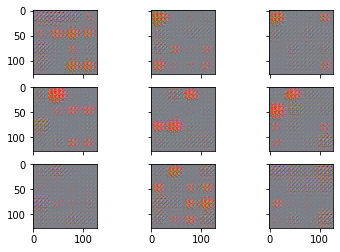

Iteration 66 of 1000 - Sun Feb 26 19:35:01 2023
Finishing ... - Sun Feb 26 19:35:02 2023
1/1 [==============================] - 0s 92ms/step
Training discriminator ... - Sun Feb 26 19:35:02 2023
Training generator ... - Sun Feb 26 19:35:02 2023
1/1 [==============================] - 0s 87ms/step
Epoch time 66 - Sun Feb 26 19:35:03 2023
Iteration 67 of 1000 - Sun Feb 26 19:35:03 2023
Finishing ... - Sun Feb 26 19:35:03 2023
1/1 [==============================] - 0s 90ms/step
Training discriminator ... - Sun Feb 26 19:35:03 2023
Training generator ... - Sun Feb 26 19:35:04 2023
1/1 [==============================] - 0s 84ms/step
Epoch time 67 - Sun Feb 26 19:35:04 2023
68 [D loss: 0.001070, acc.:100.00%] [G loss: 24.631989]
1/1 [==============================] - 0s 41ms/step


<Figure size 216x216 with 0 Axes>

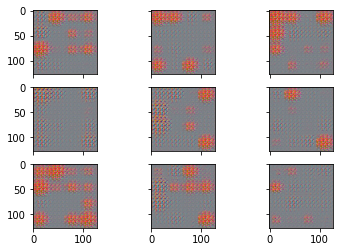

Iteration 68 of 1000 - Sun Feb 26 19:35:05 2023
Finishing ... - Sun Feb 26 19:35:05 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:35:06 2023
Training generator ... - Sun Feb 26 19:35:06 2023
1/1 [==============================] - 0s 85ms/step
Epoch time 68 - Sun Feb 26 19:35:06 2023
Iteration 69 of 1000 - Sun Feb 26 19:35:06 2023
Finishing ... - Sun Feb 26 19:35:07 2023
1/1 [==============================] - 0s 92ms/step
Training discriminator ... - Sun Feb 26 19:35:07 2023
Training generator ... - Sun Feb 26 19:35:07 2023
1/1 [==============================] - 0s 88ms/step
Epoch time 69 - Sun Feb 26 19:35:08 2023
70 [D loss: 0.007703, acc.:100.00%] [G loss: 40.926231]
1/1 [==============================] - 0s 41ms/step


<Figure size 216x216 with 0 Axes>

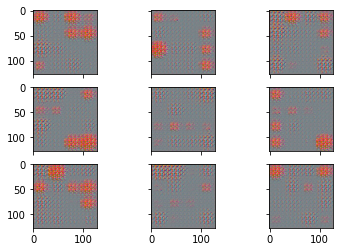

Iteration 70 of 1000 - Sun Feb 26 19:35:09 2023
Finishing ... - Sun Feb 26 19:35:09 2023
1/1 [==============================] - 0s 97ms/step
Training discriminator ... - Sun Feb 26 19:35:09 2023
Training generator ... - Sun Feb 26 19:35:10 2023
1/1 [==============================] - 0s 86ms/step
Epoch time 70 - Sun Feb 26 19:35:10 2023
Iteration 71 of 1000 - Sun Feb 26 19:35:10 2023
Finishing ... - Sun Feb 26 19:35:11 2023
1/1 [==============================] - 0s 91ms/step
Training discriminator ... - Sun Feb 26 19:35:11 2023
Training generator ... - Sun Feb 26 19:35:11 2023
1/1 [==============================] - 0s 94ms/step
Epoch time 71 - Sun Feb 26 19:35:12 2023
72 [D loss: 0.031120, acc.:98.44%] [G loss: 33.666630]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

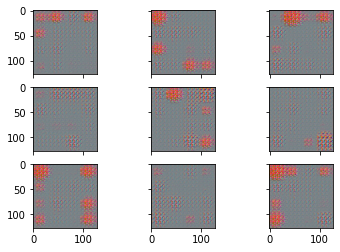

Iteration 72 of 1000 - Sun Feb 26 19:35:13 2023
Finishing ... - Sun Feb 26 19:35:13 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:35:13 2023
Training generator ... - Sun Feb 26 19:35:14 2023
1/1 [==============================] - 0s 93ms/step
Epoch time 72 - Sun Feb 26 19:35:14 2023
Iteration 73 of 1000 - Sun Feb 26 19:35:14 2023
Finishing ... - Sun Feb 26 19:35:14 2023
1/1 [==============================] - 0s 86ms/step
Training discriminator ... - Sun Feb 26 19:35:15 2023
Training generator ... - Sun Feb 26 19:35:15 2023
1/1 [==============================] - 0s 88ms/step
Epoch time 73 - Sun Feb 26 19:35:15 2023
74 [D loss: 0.007280, acc.:100.00%] [G loss: 21.423622]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

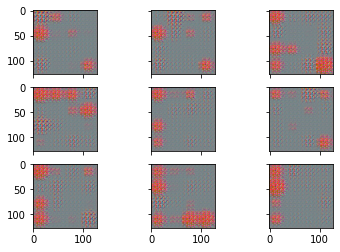

Iteration 74 of 1000 - Sun Feb 26 19:35:16 2023
Finishing ... - Sun Feb 26 19:35:17 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:35:17 2023
Training generator ... - Sun Feb 26 19:35:17 2023
1/1 [==============================] - 0s 92ms/step
Epoch time 74 - Sun Feb 26 19:35:18 2023
Iteration 75 of 1000 - Sun Feb 26 19:35:18 2023
Finishing ... - Sun Feb 26 19:35:18 2023
1/1 [==============================] - 0s 93ms/step
Training discriminator ... - Sun Feb 26 19:35:18 2023
Training generator ... - Sun Feb 26 19:35:19 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 75 - Sun Feb 26 19:35:19 2023
76 [D loss: 0.003749, acc.:100.00%] [G loss: 8.191132]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

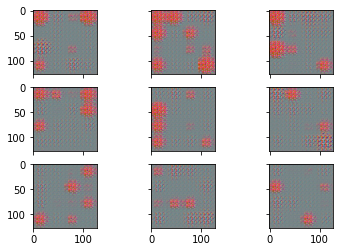

Iteration 76 of 1000 - Sun Feb 26 19:35:20 2023
Finishing ... - Sun Feb 26 19:35:20 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:35:21 2023
Training generator ... - Sun Feb 26 19:35:21 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 76 - Sun Feb 26 19:35:21 2023
Iteration 77 of 1000 - Sun Feb 26 19:35:21 2023
Finishing ... - Sun Feb 26 19:35:22 2023
1/1 [==============================] - 0s 93ms/step
Training discriminator ... - Sun Feb 26 19:35:22 2023
Training generator ... - Sun Feb 26 19:35:22 2023
1/1 [==============================] - 0s 86ms/step
Epoch time 77 - Sun Feb 26 19:35:23 2023
78 [D loss: 0.000536, acc.:100.00%] [G loss: 54.390587]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

Iteration 78 of 1000 - Sun Feb 26 19:35:24 2023
Finishing ... - Sun Feb 26 19:35:24 2023
1/1 [==============================] - 0s 103ms/step
Training discriminator ... - Sun Feb 26 19:35:24 2023
Training generator ... - Sun Feb 26 19:35:25 2023
1/1 [==============================] - 0s 109ms/step
Epoch time 78 - Sun Feb 26 19:35:25 2023
Iteration 79 of 1000 - Sun Feb 26 19:35:25 2023
Finishing ... - Sun Feb 26 19:35:26 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:35:26 2023
Training generator ... - Sun Feb 26 19:35:26 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 79 - Sun Feb 26 19:35:27 2023
80 [D loss: 0.337042, acc.:92.19%] [G loss: 74.644875]
1/1 [==============================] - 0s 49ms/step


<Figure size 216x216 with 0 Axes>

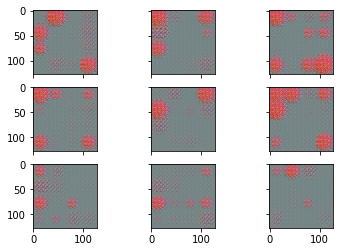

Iteration 80 of 1000 - Sun Feb 26 19:35:28 2023
Finishing ... - Sun Feb 26 19:35:28 2023
1/1 [==============================] - 0s 91ms/step
Training discriminator ... - Sun Feb 26 19:35:28 2023
Training generator ... - Sun Feb 26 19:35:29 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 80 - Sun Feb 26 19:35:29 2023
Iteration 81 of 1000 - Sun Feb 26 19:35:29 2023
Finishing ... - Sun Feb 26 19:35:29 2023
1/1 [==============================] - 0s 105ms/step
Training discriminator ... - Sun Feb 26 19:35:30 2023
Training generator ... - Sun Feb 26 19:35:30 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 81 - Sun Feb 26 19:35:30 2023
82 [D loss: 0.000001, acc.:100.00%] [G loss: 56.177483]
1/1 [==============================] - 0s 46ms/step


<Figure size 216x216 with 0 Axes>

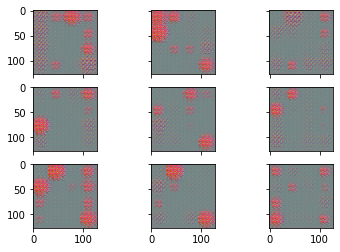

Iteration 82 of 1000 - Sun Feb 26 19:35:32 2023
Finishing ... - Sun Feb 26 19:35:32 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:35:32 2023
Training generator ... - Sun Feb 26 19:35:33 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 82 - Sun Feb 26 19:35:33 2023
Iteration 83 of 1000 - Sun Feb 26 19:35:33 2023
Finishing ... - Sun Feb 26 19:35:34 2023
1/1 [==============================] - 0s 90ms/step
Training discriminator ... - Sun Feb 26 19:35:34 2023
Training generator ... - Sun Feb 26 19:35:34 2023
1/1 [==============================] - 0s 83ms/step
Epoch time 83 - Sun Feb 26 19:35:34 2023
84 [D loss: 0.662958, acc.:98.44%] [G loss: 26.608776]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

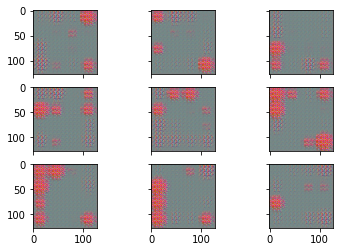

Iteration 84 of 1000 - Sun Feb 26 19:35:35 2023
Finishing ... - Sun Feb 26 19:35:36 2023
1/1 [==============================] - 0s 97ms/step
Training discriminator ... - Sun Feb 26 19:35:36 2023
Training generator ... - Sun Feb 26 19:35:36 2023
1/1 [==============================] - 0s 95ms/step
Epoch time 84 - Sun Feb 26 19:35:37 2023
Iteration 85 of 1000 - Sun Feb 26 19:35:37 2023
Finishing ... - Sun Feb 26 19:35:37 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:35:37 2023
Training generator ... - Sun Feb 26 19:35:38 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 85 - Sun Feb 26 19:35:38 2023
86 [D loss: 0.348397, acc.:92.19%] [G loss: 47.623260]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

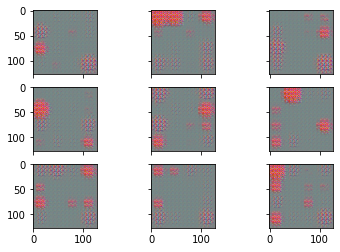

Iteration 86 of 1000 - Sun Feb 26 19:35:39 2023
Finishing ... - Sun Feb 26 19:35:40 2023
1/1 [==============================] - 0s 96ms/step
Training discriminator ... - Sun Feb 26 19:35:40 2023
Training generator ... - Sun Feb 26 19:35:40 2023
1/1 [==============================] - 0s 87ms/step
Epoch time 86 - Sun Feb 26 19:35:41 2023
Iteration 87 of 1000 - Sun Feb 26 19:35:41 2023
Finishing ... - Sun Feb 26 19:35:41 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:35:41 2023
Training generator ... - Sun Feb 26 19:35:42 2023
1/1 [==============================] - 0s 95ms/step
Epoch time 87 - Sun Feb 26 19:35:42 2023
88 [D loss: 1.027266, acc.:85.94%] [G loss: 15.627419]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

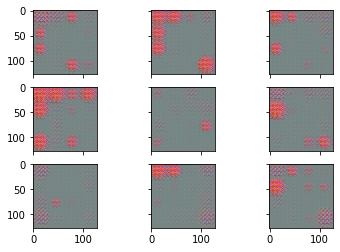

Iteration 88 of 1000 - Sun Feb 26 19:35:43 2023
Finishing ... - Sun Feb 26 19:35:44 2023
1/1 [==============================] - 0s 101ms/step
Training discriminator ... - Sun Feb 26 19:35:44 2023
Training generator ... - Sun Feb 26 19:35:44 2023
1/1 [==============================] - 0s 91ms/step
Epoch time 88 - Sun Feb 26 19:35:45 2023
Iteration 89 of 1000 - Sun Feb 26 19:35:45 2023
Finishing ... - Sun Feb 26 19:35:45 2023
1/1 [==============================] - 0s 92ms/step
Training discriminator ... - Sun Feb 26 19:35:45 2023
Training generator ... - Sun Feb 26 19:35:46 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 89 - Sun Feb 26 19:35:46 2023
90 [D loss: 0.087130, acc.:98.44%] [G loss: 21.066845]
1/1 [==============================] - 0s 40ms/step


<Figure size 216x216 with 0 Axes>

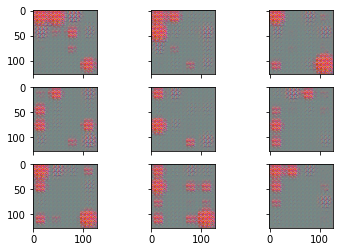

Iteration 90 of 1000 - Sun Feb 26 19:35:47 2023
Finishing ... - Sun Feb 26 19:35:48 2023
1/1 [==============================] - 0s 82ms/step
Training discriminator ... - Sun Feb 26 19:35:48 2023
Training generator ... - Sun Feb 26 19:35:48 2023
1/1 [==============================] - 0s 92ms/step
Epoch time 90 - Sun Feb 26 19:35:49 2023
Iteration 91 of 1000 - Sun Feb 26 19:35:49 2023
Finishing ... - Sun Feb 26 19:35:49 2023
1/1 [==============================] - 0s 86ms/step
Training discriminator ... - Sun Feb 26 19:35:49 2023
Training generator ... - Sun Feb 26 19:35:50 2023
1/1 [==============================] - 0s 81ms/step
Epoch time 91 - Sun Feb 26 19:35:50 2023
92 [D loss: 0.031551, acc.:98.44%] [G loss: 30.428749]
1/1 [==============================] - 0s 38ms/step


<Figure size 216x216 with 0 Axes>

Iteration 92 of 1000 - Sun Feb 26 19:35:51 2023
Finishing ... - Sun Feb 26 19:35:51 2023
1/1 [==============================] - 0s 88ms/step
Training discriminator ... - Sun Feb 26 19:35:51 2023
Training generator ... - Sun Feb 26 19:35:52 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 92 - Sun Feb 26 19:35:52 2023
Iteration 93 of 1000 - Sun Feb 26 19:35:52 2023
Finishing ... - Sun Feb 26 19:35:53 2023
1/1 [==============================] - 0s 90ms/step
Training discriminator ... - Sun Feb 26 19:35:53 2023
Training generator ... - Sun Feb 26 19:35:53 2023
1/1 [==============================] - 0s 91ms/step
Epoch time 93 - Sun Feb 26 19:35:54 2023
94 [D loss: 0.000244, acc.:100.00%] [G loss: 26.004776]
1/1 [==============================] - 0s 52ms/step


<Figure size 216x216 with 0 Axes>

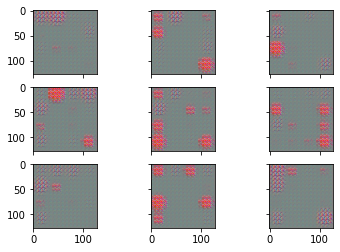

Iteration 94 of 1000 - Sun Feb 26 19:35:55 2023
Finishing ... - Sun Feb 26 19:35:55 2023
1/1 [==============================] - 0s 86ms/step
Training discriminator ... - Sun Feb 26 19:35:56 2023
Training generator ... - Sun Feb 26 19:35:56 2023
1/1 [==============================] - 0s 83ms/step
Epoch time 94 - Sun Feb 26 19:35:56 2023
Iteration 95 of 1000 - Sun Feb 26 19:35:56 2023
Finishing ... - Sun Feb 26 19:35:57 2023
1/1 [==============================] - 0s 87ms/step
Training discriminator ... - Sun Feb 26 19:35:57 2023
Training generator ... - Sun Feb 26 19:35:57 2023
1/1 [==============================] - 0s 94ms/step
Epoch time 95 - Sun Feb 26 19:35:58 2023
96 [D loss: 0.005549, acc.:100.00%] [G loss: 15.309673]
1/1 [==============================] - 0s 47ms/step


<Figure size 216x216 with 0 Axes>

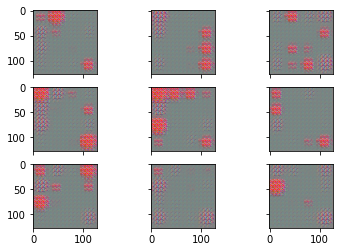

Iteration 96 of 1000 - Sun Feb 26 19:35:59 2023
Finishing ... - Sun Feb 26 19:35:59 2023
1/1 [==============================] - 0s 92ms/step
Training discriminator ... - Sun Feb 26 19:35:59 2023
Training generator ... - Sun Feb 26 19:36:00 2023
1/1 [==============================] - 0s 94ms/step
Epoch time 96 - Sun Feb 26 19:36:00 2023
Iteration 97 of 1000 - Sun Feb 26 19:36:00 2023
Finishing ... - Sun Feb 26 19:36:01 2023
1/1 [==============================] - 0s 91ms/step
Training discriminator ... - Sun Feb 26 19:36:01 2023
Training generator ... - Sun Feb 26 19:36:01 2023
1/1 [==============================] - 0s 88ms/step
Epoch time 97 - Sun Feb 26 19:36:02 2023
98 [D loss: 0.219978, acc.:93.75%] [G loss: 11.410398]
1/1 [==============================] - 0s 46ms/step


<Figure size 216x216 with 0 Axes>

Iteration 98 of 1000 - Sun Feb 26 19:36:03 2023
Finishing ... - Sun Feb 26 19:36:03 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:36:03 2023
Training generator ... - Sun Feb 26 19:36:04 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 98 - Sun Feb 26 19:36:04 2023
Iteration 99 of 1000 - Sun Feb 26 19:36:04 2023
Finishing ... - Sun Feb 26 19:36:04 2023
1/1 [==============================] - 0s 97ms/step
Training discriminator ... - Sun Feb 26 19:36:05 2023
Training generator ... - Sun Feb 26 19:36:05 2023
1/1 [==============================] - 0s 86ms/step
Epoch time 99 - Sun Feb 26 19:36:05 2023
100 [D loss: 0.002759, acc.:100.00%] [G loss: 16.552563]
1/1 [==============================] - 0s 42ms/step


<Figure size 216x216 with 0 Axes>

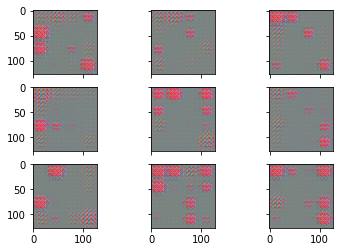

Iteration 100 of 1000 - Sun Feb 26 19:36:06 2023
Finishing ... - Sun Feb 26 19:36:07 2023
1/1 [==============================] - 0s 96ms/step
Training discriminator ... - Sun Feb 26 19:36:07 2023
Training generator ... - Sun Feb 26 19:36:07 2023
1/1 [==============================] - 0s 87ms/step
Epoch time 100 - Sun Feb 26 19:36:08 2023
Iteration 101 of 1000 - Sun Feb 26 19:36:08 2023
Finishing ... - Sun Feb 26 19:36:08 2023
1/1 [==============================] - 0s 93ms/step
Training discriminator ... - Sun Feb 26 19:36:08 2023
Training generator ... - Sun Feb 26 19:36:09 2023
1/1 [==============================] - 0s 92ms/step
Epoch time 101 - Sun Feb 26 19:36:09 2023
102 [D loss: 0.001228, acc.:100.00%] [G loss: 16.257896]
1/1 [==============================] - 0s 40ms/step


<Figure size 216x216 with 0 Axes>

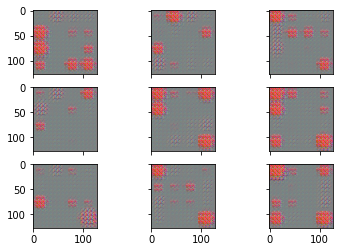

Iteration 102 of 1000 - Sun Feb 26 19:36:10 2023
Finishing ... - Sun Feb 26 19:36:10 2023
1/1 [==============================] - 0s 100ms/step
Training discriminator ... - Sun Feb 26 19:36:11 2023
Training generator ... - Sun Feb 26 19:36:11 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 102 - Sun Feb 26 19:36:11 2023
Iteration 103 of 1000 - Sun Feb 26 19:36:11 2023
Finishing ... - Sun Feb 26 19:36:12 2023
1/1 [==============================] - 0s 95ms/step
Training discriminator ... - Sun Feb 26 19:36:12 2023
Training generator ... - Sun Feb 26 19:36:12 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 103 - Sun Feb 26 19:36:13 2023
104 [D loss: 0.260071, acc.:93.75%] [G loss: 25.542355]
1/1 [==============================] - 0s 41ms/step


<Figure size 216x216 with 0 Axes>

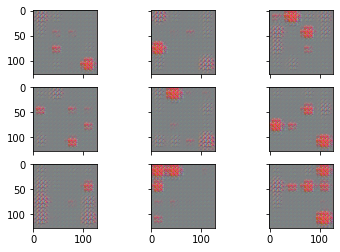

Iteration 104 of 1000 - Sun Feb 26 19:36:14 2023
Finishing ... - Sun Feb 26 19:36:14 2023
1/1 [==============================] - 0s 90ms/step
Training discriminator ... - Sun Feb 26 19:36:14 2023
Training generator ... - Sun Feb 26 19:36:15 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 104 - Sun Feb 26 19:36:15 2023
Iteration 105 of 1000 - Sun Feb 26 19:36:15 2023
Finishing ... - Sun Feb 26 19:36:16 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:36:16 2023
Training generator ... - Sun Feb 26 19:36:16 2023
1/1 [==============================] - 0s 88ms/step
Epoch time 105 - Sun Feb 26 19:36:16 2023
106 [D loss: 0.000114, acc.:100.00%] [G loss: 40.935768]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

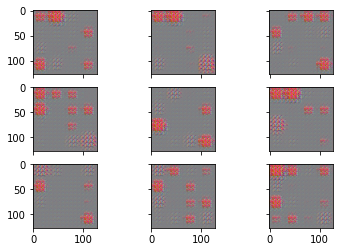

Iteration 106 of 1000 - Sun Feb 26 19:36:18 2023
Finishing ... - Sun Feb 26 19:36:18 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:36:18 2023
Training generator ... - Sun Feb 26 19:36:19 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 106 - Sun Feb 26 19:36:19 2023
Iteration 107 of 1000 - Sun Feb 26 19:36:19 2023
Finishing ... - Sun Feb 26 19:36:19 2023
1/1 [==============================] - 0s 90ms/step
Training discriminator ... - Sun Feb 26 19:36:20 2023
Training generator ... - Sun Feb 26 19:36:20 2023
1/1 [==============================] - 0s 90ms/step
Epoch time 107 - Sun Feb 26 19:36:20 2023
108 [D loss: 0.000037, acc.:100.00%] [G loss: 25.800270]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

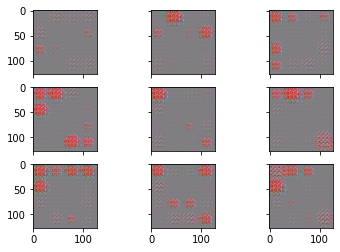

Iteration 108 of 1000 - Sun Feb 26 19:36:22 2023
Finishing ... - Sun Feb 26 19:36:22 2023
1/1 [==============================] - 0s 104ms/step
Training discriminator ... - Sun Feb 26 19:36:22 2023
Training generator ... - Sun Feb 26 19:36:23 2023
1/1 [==============================] - 0s 91ms/step
Epoch time 108 - Sun Feb 26 19:36:23 2023
Iteration 109 of 1000 - Sun Feb 26 19:36:23 2023
Finishing ... - Sun Feb 26 19:36:23 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:36:24 2023
Training generator ... - Sun Feb 26 19:36:24 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 109 - Sun Feb 26 19:36:24 2023
110 [D loss: 0.223429, acc.:93.75%] [G loss: 43.639328]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

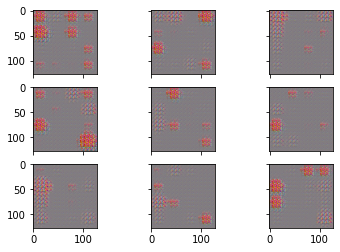

Iteration 110 of 1000 - Sun Feb 26 19:36:25 2023
Finishing ... - Sun Feb 26 19:36:26 2023
1/1 [==============================] - 0s 90ms/step
Training discriminator ... - Sun Feb 26 19:36:26 2023
Training generator ... - Sun Feb 26 19:36:26 2023
1/1 [==============================] - 0s 91ms/step
Epoch time 110 - Sun Feb 26 19:36:27 2023
Iteration 111 of 1000 - Sun Feb 26 19:36:27 2023
Finishing ... - Sun Feb 26 19:36:27 2023
1/1 [==============================] - 0s 98ms/step
Training discriminator ... - Sun Feb 26 19:36:27 2023
Training generator ... - Sun Feb 26 19:36:28 2023
1/1 [==============================] - 0s 86ms/step
Epoch time 111 - Sun Feb 26 19:36:28 2023
112 [D loss: 0.392638, acc.:93.75%] [G loss: 17.938974]
1/1 [==============================] - 0s 47ms/step


<Figure size 216x216 with 0 Axes>

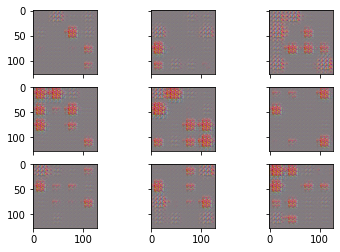

Iteration 112 of 1000 - Sun Feb 26 19:36:29 2023
Finishing ... - Sun Feb 26 19:36:30 2023
1/1 [==============================] - 0s 89ms/step
Training discriminator ... - Sun Feb 26 19:36:30 2023
Training generator ... - Sun Feb 26 19:36:30 2023
1/1 [==============================] - 0s 89ms/step
Epoch time 112 - Sun Feb 26 19:36:31 2023
Iteration 113 of 1000 - Sun Feb 26 19:36:31 2023
Finishing ... - Sun Feb 26 19:36:31 2023
1/1 [==============================] - 0s 91ms/step
Training discriminator ... - Sun Feb 26 19:36:31 2023
Training generator ... - Sun Feb 26 19:36:31 2023
1/1 [==============================] - 0s 101ms/step
Epoch time 113 - Sun Feb 26 19:36:32 2023
114 [D loss: 0.026485, acc.:98.44%] [G loss: 27.218264]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

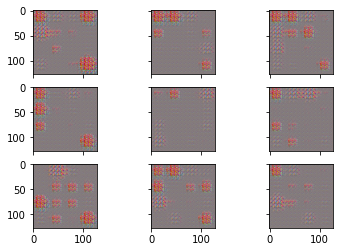

Iteration 114 of 1000 - Sun Feb 26 19:36:33 2023
Finishing ... - Sun Feb 26 19:36:33 2023
1/1 [==============================] - 0s 96ms/step
Training discriminator ... - Sun Feb 26 19:36:34 2023
Training generator ... - Sun Feb 26 19:36:34 2023
1/1 [==============================] - 0s 95ms/step
Epoch time 114 - Sun Feb 26 19:36:34 2023
Iteration 115 of 1000 - Sun Feb 26 19:36:34 2023
Finishing ... - Sun Feb 26 19:36:35 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:36:35 2023
Training generator ... - Sun Feb 26 19:36:35 2023
1/1 [==============================] - 0s 95ms/step
Epoch time 115 - Sun Feb 26 19:36:36 2023
116 [D loss: 0.038734, acc.:98.44%] [G loss: 33.289463]
1/1 [==============================] - 0s 48ms/step


<Figure size 216x216 with 0 Axes>

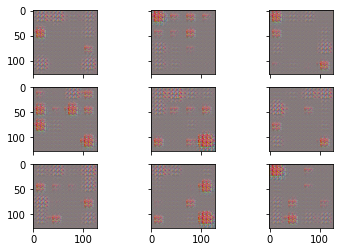

Iteration 116 of 1000 - Sun Feb 26 19:36:37 2023
Finishing ... - Sun Feb 26 19:36:37 2023
1/1 [==============================] - 0s 94ms/step
Training discriminator ... - Sun Feb 26 19:36:38 2023
Training generator ... - Sun Feb 26 19:36:38 2023
1/1 [==============================] - 0s 97ms/step
Epoch time 116 - Sun Feb 26 19:36:38 2023
Iteration 117 of 1000 - Sun Feb 26 19:36:38 2023
Finishing ... - Sun Feb 26 19:36:39 2023
1/1 [==============================] - 0s 92ms/step
Training discriminator ... - Sun Feb 26 19:36:39 2023
Training generator ... - Sun Feb 26 19:36:39 2023
1/1 [==============================] - 0s 84ms/step
Epoch time 117 - Sun Feb 26 19:36:40 2023
118 [D loss: 0.001811, acc.:100.00%] [G loss: 22.370384]
1/1 [==============================] - 0s 44ms/step


<Figure size 216x216 with 0 Axes>

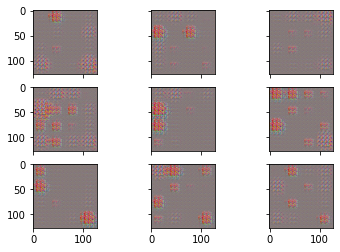

Iteration 118 of 1000 - Sun Feb 26 19:36:41 2023
Finishing ... - Sun Feb 26 19:36:41 2023
1/1 [==============================] - 0s 96ms/step
Training discriminator ... - Sun Feb 26 19:36:42 2023
Training generator ... - Sun Feb 26 19:36:42 2023
1/1 [==============================] - 0s 86ms/step
Epoch time 118 - Sun Feb 26 19:36:42 2023
Iteration 119 of 1000 - Sun Feb 26 19:36:42 2023
Finishing ... - Sun Feb 26 19:36:43 2023
1/1 [==============================] - 0s 93ms/step
Training discriminator ... - Sun Feb 26 19:36:43 2023
Training generator ... - Sun Feb 26 19:36:43 2023
1/1 [==============================] - 0s 87ms/step
Epoch time 119 - Sun Feb 26 19:36:44 2023
120 [D loss: 0.017391, acc.:98.44%] [G loss: 20.698772]
1/1 [==============================] - 0s 46ms/step


<Figure size 216x216 with 0 Axes>

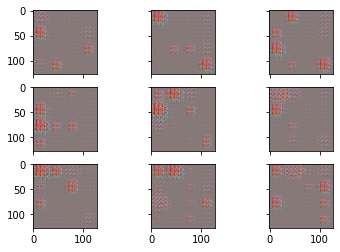

Iteration 120 of 1000 - Sun Feb 26 19:36:45 2023
Finishing ... - Sun Feb 26 19:36:45 2023
1/1 [==============================] - 0s 96ms/step
Training discriminator ... - Sun Feb 26 19:36:45 2023
Training generator ... - Sun Feb 26 19:36:46 2023
1/1 [==============================] - 0s 88ms/step
Epoch time 120 - Sun Feb 26 19:36:46 2023
Iteration 121 of 1000 - Sun Feb 26 19:36:46 2023
Finishing ... - Sun Feb 26 19:36:47 2023
1/1 [==============================] - 0s 91ms/step
Training discriminator ... - Sun Feb 26 19:36:47 2023
Training generator ... - Sun Feb 26 19:36:47 2023
1/1 [==============================] - 0s 87ms/step
Epoch time 121 - Sun Feb 26 19:36:48 2023
122 [D loss: 0.000008, acc.:100.00%] [G loss: 23.172617]
1/1 [==============================] - 0s 43ms/step


<Figure size 216x216 with 0 Axes>

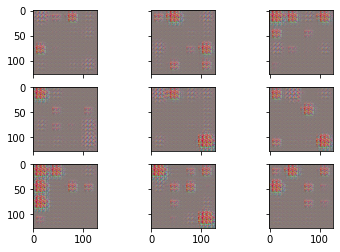

Iteration 122 of 1000 - Sun Feb 26 19:36:49 2023
Finishing ... - Sun Feb 26 19:36:49 2023
1/1 [==============================] - 0s 97ms/step
Training discriminator ... - Sun Feb 26 19:36:49 2023


KeyboardInterrupt: 

In [42]:
train_gan(iterations, batch_size, sample_interval)

In [ ]:
plt.plot(gan_losses)

In [ ]:
plt.plot(discriminator_losses)